In [1]:
import pickle
import argparse
import itertools

import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scipy

import sys
sys.path.append('../scripts/observation')

import tinystories_null as ts

INFO 10-05 01:29:38 __init__.py:190] Automatically detected platform cpu.


In [28]:
def z_to_p(z_score):
    # z_score *= np.sqrt(9/8) * (1/(1+1E-6))
    return scipy.stats.norm.sf(z_score)

def z_to_logp(z_score):
    return np.log10(scipy.stats.norm.sf(z_score))

def get_default_args(save_dir):
    parser = argparse.ArgumentParser()
    
    parser.add_argument("--save_dir", type=str, required=True)
    parser.add_argument("--batch_size", type=int, default=4)
    parser.add_argument("--n_partial_0", type=int, default=0)
    parser.add_argument("--num_partial_models", type=int, default=1)
    parser.add_argument("--n_base", type=int, default=1)
    parser.add_argument("--n_finetune", type=int, default=0)
    parser.add_argument("--n_sample", type=int, default=100)
    parser.add_argument("--temperature", type=float, default=1.0)
    parser.add_argument("--seed", type=int, default=0)
    parser.add_argument("--shuffle_seed", type=int, default=0)
    parser.add_argument("--sampling_seed", type=int, default=0)
    parser.add_argument("--num_shuffles", type=int, default=10)
    parser.add_argument("--prompt", type=str, default=None)
    parser.add_argument("--finetune_on_test", type=str, default="false")
    parser.add_argument("--reinit_ft_optimizer", type=str, default="true")
    parser.add_argument("--partial_model_index", type=int, default=0)
    parser.add_argument("--hidden_size", type=int, default=256)
    parser.add_argument("--intermediate_size", type=int, default=512)
    parser.add_argument("--num_hidden_layers", type=int, default=4)
    parser.add_argument("--num_attention_heads", type=int, default=8)
    parser.add_argument("--max_position_embeddings", type=int, default=512)
    parser.add_argument("--max_tokens", type=int, default=32)
    parser.add_argument("--learning_rate", type=float, default=1e-5)
    parser.add_argument("--include_hash", type=str, default="false")
    parser.add_argument("--null_model_path", type=str, default=None)

    args = parser.parse_args(["--save_dir", save_dir])

    return args

def set_args(args, args_dict):
    for k,v in args_dict.items():
        setattr(args, k, v)

def get_experiment(experiment_config, new_root='../not-a-test', old_root='./not-a-test'):
    args = get_default_args(save_dir=old_root)
    set_args(args, experiment_config)
    ts.update_experiment_args(args)

    old_path = ts.get_experiment_log_path(args)
    relative_path = os.path.relpath(old_path, old_root)
    new_path = os.path.join(new_root, relative_path)

    experiment_result = pickle.load(open(new_path,'rb'))
    
    return experiment_result
    

def get_experiment_sweep(
    sweep_configs, 
    new_root='../not-a-test', 
    old_root='./not-a-test'
):
    param_names = list(sweep_configs.keys())
    param_names.reverse()
    param_values = [sweep_configs[name] for name in param_names]
    param_combinations = list(itertools.product(*param_values))

    experiment_configs = [dict(zip(param_names, params)) for params in param_combinations]

    
    results = []
    for experiment_config in experiment_configs:
        experiment_result = get_experiment(experiment_config, new_root, old_root)
        results.append(z_to_p(experiment_result["z_score"]))

    return results

def get_plot(
    sweep_configs,
    xlabel="x",
    ylabel="probability that p < x",
    bin_size=0.01,
    new_root='../not-a-test', 
    old_root='./not-a-test',
):
    
    sns.set_theme()
    sns.set_palette("mako")
    plt.figure() 
    
    results = get_experiment_sweep(sweep_configs, new_root, old_root)
    print(min(results))
    print(len(results))
    xs = np.arange(0, 1+bin_size, bin_size)
    ys = [np.mean(results < x) for x in xs]
    
    plt.scatter(xs, ys)
    
    plt.xlabel(xlabel); plt.ylabel(ylabel); plt.legend(); plt.tight_layout(); plt.show()

def get_colors(k):
    return sns.color_palette("mako", n_colors=k)

def compute_subsampled_plot(
    shuffle_metrics_path,
    n_sample,
    T = None,
    xlabel="x",
    ylabel="probability that p < x",
    bin_size = 0.01,
    save_path=None,
):
    shuffle_metrics = pickle.load(open(shuffle_metrics_path, 'rb'))
    if T is None:
        T = int(len(shuffle_metrics[0]) / n_sample)

    z_scores = []
    for t in range(T):
        indices = np.random.choice(len(shuffle_metrics[0]), size=n_sample, replace=False)
        subsampled_metrics = [[shuffle_metrics[i][idx] for idx in indices] for i in range(len(shuffle_metrics))]
        subsampled_metrics = [np.mean(metrics) for metrics in subsampled_metrics]

        Z_SCORE_EPS = 1E-6
        z_score = (subsampled_metrics[-1] - np.mean(subsampled_metrics[:-1])) / (np.std(subsampled_metrics[:-1]) + Z_SCORE_EPS)
        z_scores.append(z_score)
    

    results = [z_to_p(z_score) for z_score in z_scores]
    # print(len(results))
    # print(min(results))
    # sorted_results = sorted(results)
    # print(sorted_results[:5])
    xs = np.arange(0, 1+bin_size, bin_size)
    # xs = np.arange(0, 1, bin_size)
    ys = [np.mean(results < x) for x in xs]

    plt.scatter(xs, ys)
    
    plt.xlabel(xlabel); plt.ylabel(ylabel); plt.legend(); plt.tight_layout()
    if save_path is not None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    

0.016984618683972098
100


/var/folders/m5/gjt65pg949x17sxgysw53qmh0000gn/T/ipykernel_9393/857569556.py:100: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.xlabel(xlabel); plt.ylabel(ylabel); plt.legend(); plt.tight_layout(); plt.show()


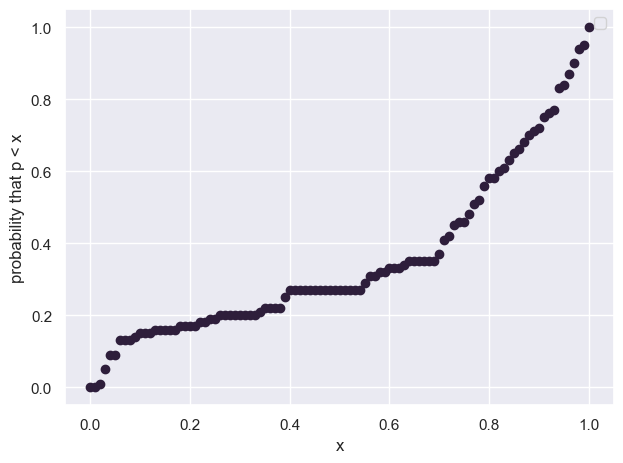

In [3]:
sweep_configs = {
    "save_dir": ["./not-a-test"],
    "n_partial_0": [450000],
    "n_base": [500000],
    "seed": [42],
    "num_partial_models": [5],
    "partial_model_index": list(range(5)),
    "num_shuffles": [10],
    "n_sample": [10],
    "sampling_seed": list(range(10)),
    "finetune_on_test": ["true", "false"],
    "null_model_path": ["./null-models/tinystories/default"],
}

get_plot(sweep_configs)

/var/folders/m5/gjt65pg949x17sxgysw53qmh0000gn/T/ipykernel_9393/174774515.py:140: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.xlabel(xlabel); plt.ylabel(ylabel); plt.legend(); plt.tight_layout()


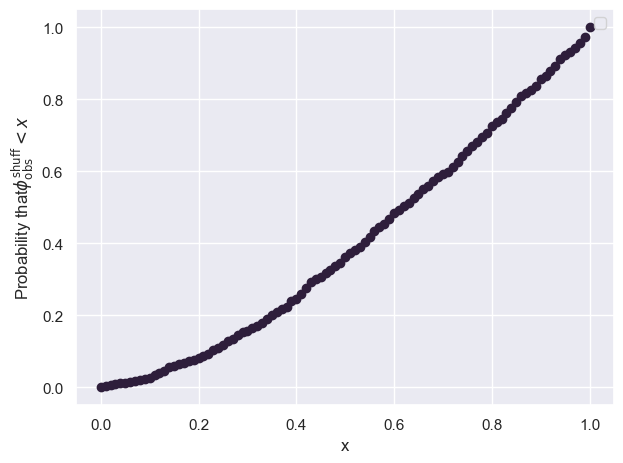

In [41]:
compute_subsampled_plot(
    shuffle_metrics_path="../not-a-test/metrics/88119488af1fafbf/shuffle_metrics.pkl",
    n_sample=100,
    T = 1000,
    save_path="../figures/appendix-tinystories-null-distribution.png",
    ylabel="Probability that$\phi_{\mathrm{{obs}}}^{\mathrm{{shuff}}} < x$",
)